In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import nibabel as nib
import SimpleITK as sitk
import napari

import plotly.express as px
import plotly.graph_objects as go

from scipy import ndimage
from scipy.ndimage import gaussian_filter
import open3d as o3d

from skimage.util import random_noise
from skimage import feature
from skimage import filters
from skimage import measure
from scipy.ndimage import affine_transform

from scipy.sparse import csr_matrix, linalg as sla

from registration.reg_utils import *
from registration.plot_utils import *
from registration.edge_utils import *

import open3d
import os
import gc
#from mayavi import mlab

import scipy
import pyamg

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
fixedImagePath = "../CCF_DATA/average_template_100.nii"
movingImagePath = "../../registration/B39/brain_100.nii.gz"
axisAlignedDataPath = "../reg/axisAlignedData.nii.gz"

In [5]:
fdata, mdata, adata = loadNiiImages([fixedImagePath, movingImagePath, axisAlignedDataPath], scale=True)

In [6]:
nx, ny, nz  = fdata.shape
nd  = len(fdata.shape)
spacing = 100
fthresh = 5
mthresh =75
rd = RegistrationData(fdata, mdata, spacing, fthresh, mthresh)

# Initial Point Clouds

In [23]:
mpoints = rd.mpoints
fpoints = rd.fpoints

#A_ = scaleAffineTransform(A1, rd100.scale)
#fpoints = rg.affineTransformPointCloud(rd100.fpoints,A_)
"""
fpoints =np.array( fsurface.nonzero()).T
A_ = scaleAffineTra
nsform(A1, rd100.scale)
fpoints = rg.affineTransformPointCloud(fpoints,A_).T
"""
#mx_lines,my_lines,mz_lines = get_lines(np.asarray(mpcd.points),np.asarray(mpcd.normals))

fig = go.Figure(data=[go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers', name = "Moving Data")])

#fig.add_trace(go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers'))

fig.add_trace(go.Scatter3d(x=fpoints[:,0], y=fpoints[:,1], z=fpoints[:,2],mode='markers', name  = "Fixed Template"))

#fig.add_trace(go.Scatter3d(x=mx_lines,y=my_lines,z=mz_lines,mode='lines',name='lines'))

fig.update_traces(marker=dict(size=1))

fig.update_layout(title={
        'text': "Inital Point Clouds Computed",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, autosize=True) 

fig.show(renderer='browser')

# Scaling

In [7]:
mpoints = rd.mpoints.copy()
fpoints = rd.fpoints.copy()

S = getScaleMatrix(rd.fbinary, rd.mbinary)
mpoints= affineTransformPointCloud(rd.mpoints,S)

In [27]:
mpoints = mpoints
fpoints = rd.fpoints

#A_ = scaleAffineTransform(A1, rd100.scale)
#fpoints = rg.affineTransformPointCloud(rd100.fpoints,A_)
"""
fpoints =np.array( fsurface.nonzero()).T
A_ = scaleAffineTra
nsform(A1, rd100.scale)
fpoints = rg.affineTransformPointCloud(fpoints,A_).T
"""
#mx_lines,my_lines,mz_lines = get_lines(np.asarray(mpcd.points),np.asarray(mpcd.normals))

fig = go.Figure(data=[go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers', name = "Moving Data")])

#fig.add_trace(go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers'))

fig.add_trace(go.Scatter3d(x=fpoints[:,0], y=fpoints[:,1], z=fpoints[:,2],mode='markers', name  = "Fixed Template"))

#fig.add_trace(go.Scatter3d(x=mx_lines,y=my_lines,z=mz_lines,mode='lines',name='lines'))

fig.update_traces(marker=dict(size=1))

fig.update_layout(title={
        'text': "Point Clouds Scaled",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, autosize=True) 

fig.show(renderer='browser')

# Translation

In [8]:
T = getCenterTranslationMatrix(fpoints, mpoints)
mpoints= affineTransformPointCloud(rd.mpoints,T@S)
R = align_principle_axes(fpoints, mpoints)
R = np.eye(4)
A1 = R@T@S
#mpoints = affineTransformPointCloud(rd.mpoints,A1)
rd.set_mpoints(mpoints)

In [29]:
mpoints = rd.mpoints
fpoints = rd.fpoints

#A_ = scaleAffineTransform(A1, rd100.scale)
#fpoints = rg.affineTransformPointCloud(rd100.fpoints,A_)
"""
fpoints =np.array( fsurface.nonzero()).T
A_ = scaleAffineTra
nsform(A1, rd100.scale)
fpoints = rg.affineTransformPointCloud(fpoints,A_).T
"""
#mx_lines,my_lines,mz_lines = get_lines(np.asarray(mpcd.points),np.asarray(mpcd.normals))

fig = go.Figure(data=[go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers', name = "Moving Data")])

#fig.add_trace(go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers'))

fig.add_trace(go.Scatter3d(x=fpoints[:,0], y=fpoints[:,1], z=fpoints[:,2],mode='markers', name  = "Fixed Template"))

#fig.add_trace(go.Scatter3d(x=mx_lines,y=my_lines,z=mz_lines,mode='lines',name='lines'))

fig.update_traces(marker=dict(size=1))

fig.update_layout(title={
        'text': "Scaled and Translated Point Clouds",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, autosize=True) 

fig.show(renderer='browser')

# Estimating Normals

In [9]:
rd.estimate_fnormals()
rd.estimate_mnormals()

27652it [00:03, 6963.48it/s]
25522it [00:03, 7367.78it/s]


In [35]:
mpoints = rd.mpoints
fpoints = rd.fpoints
mnormals = rd.mnormals
#A_ = scaleAffineTransform(A1, rd100.scale)
#fpoints = rg.affineTransformPointCloud(rd100.fpoints,A_)
"""
fpoints =np.array( fsurface.nonzero()).T
A_ = scaleAffineTra
nsform(A1, rd100.scale)
fpoints = rg.affineTransformPointCloud(fpoints,A_).T
"""
mx_lines,my_lines,mz_lines = get_lines(np.asarray(mpoints),np.asarray(mnormals))

fig = go.Figure(data=[go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers', name = "Moving Data")])

#fig.add_trace(go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers'))

#fig.add_trace(go.Scatter3d(x=fpoints[:,0], y=fpoints[:,1], z=fpoints[:,2],mode='markers', name  = "Fixed Template"))

fig.add_trace(go.Scatter3d(x=mx_lines,y=my_lines,z=mz_lines,mode='lines',name='Normals'))

fig.update_traces(marker=dict(size=1))

fig.update_layout(title={
        'text': "Normals computed on Moving Point cloud",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, autosize=True) 

fig.show(renderer='browser')

In [38]:
mpoints = rd.mpoints
fpoints = rd.fpoints

correspondences =[]

for s,point in tqdm(enumerate(fpoints)):
    correspondences.append(get_correspondences( point, fnormals[s], mnormals, rd.mkdtree, 5,100 ))

fig = go.Figure(data=[go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers', name = "Moving Point Cloud")])

fig.add_trace(go.Scatter3d(x=fpoints[:,0], y=fpoints[:,1], z=fpoints[:,2],mode='markers', name="Fixed Point Cloud"))

cx_lines,cy_lines,cz_lines = get_correspondence_lines(fpoints,mpoints, correspondences)

fig.add_trace(go.Scatter3d(x=cx_lines,y=cy_lines,z=cz_lines,mode='lines',name='Correspondences'))

fig.update_traces(marker=dict(size=1))

fig.update_layout(title={
        'text': "3D Correspondences",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, autosize=True) 

fig.show(renderer='browser')

26375it [00:02, 12021.07it/s]


# Affine transform

In [10]:
A2 = icp_registration(rd)

A= A2@A1
A[3] = [0,0,0,1]
rd.applyAffineTransform(A)

 28%|███████████████████████▏                                                           | 7/25 [00:31<01:20,  4.45s/it]
26970it [00:03, 7110.47it/s]


In [11]:
mpoints = rd.mpoints
fpoints = rd.fpoints


fig = go.Figure(data=[go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers', name = "Moving Data")])

#fig.add_trace(go.Scatter3d(x=mpoints[:,0], y=mpoints[:,1], z=mpoints[:,2],mode='markers'))

fig.add_trace(go.Scatter3d(x=fpoints[:,0], y=fpoints[:,1], z=fpoints[:,2],mode='markers', name  = "Fixed Template"))

#fig.add_trace(go.Scatter3d(x=mx_lines,y=my_lines,z=mz_lines,mode='lines',name='lines'))

fig.update_traces(marker=dict(size=1))

fig.update_layout(title={
        'text': "Affine Registered Point Clouds",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, autosize=True) 

fig.show(renderer='browser')

# Non Linear Registration

In [13]:
from registration.laplacian3DRegistration import *

In [16]:
deformationField = np.zeros((nd, nx, ny, nz))

dx, dy,dz = nonLinearRegistration(rd , tol =1e-5)

deformationField[0] = dx
deformationField[1] = dy
deformationField[2] = dz
transformedData   = applyDeformationField(rd.mdata , deformationField)

27652it [00:02, 12609.21it/s]


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
dx calculated in 12.113000392913818s
dy calculated in 24.56403422355652s
dz calculated in 36.79703378677368s


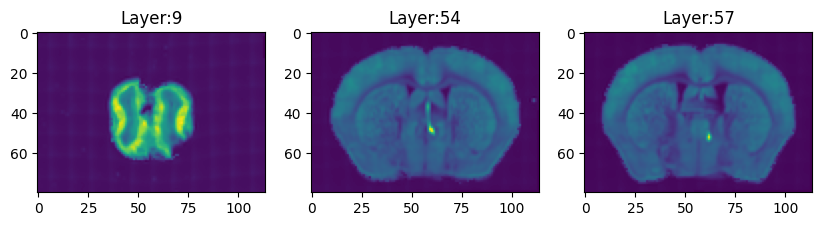

In [17]:
plot_samples(transformedData)